### Introduction

Image segmentation is the process of partitioning a digital image into multiple segments to make the image easier to analyze<sup>[[1]](https://en.wikipedia.org/wiki/Image_segmentation)</sup>. In this notebook I will implement a classical technique of thresholding for image segmentation. Thresholding is a type of image segmentation that isolates objects by converting grayscale images into binary images. Image thresholding is most effective in images with high levels of contrast like image of the black bicyle before white backgorund I have used here. 

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

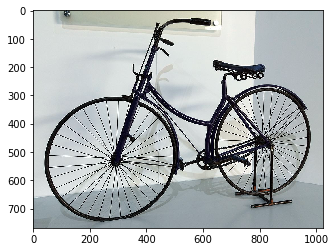

In [13]:
#Loading image
img = cv2.imread("bicycle.jpg")
plt.imshow(img)

#Image Credit: https://en.wikipedia.org/wiki/Bicycle#/media/File:1886_Starley_%27Rover%27_Safety_Cycle_British_Motor_Museum_09-2016_(29928044262).jpg

### Denoising Image
Denoising using blurring can remove some of image details especially the background, this helps in identifying the edges later.

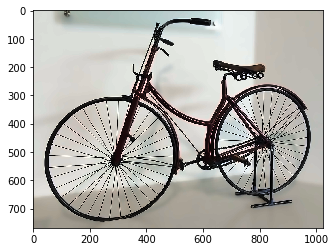

In [21]:
hColor = h = 22    
    
blur = cv2.fastNlMeansDenoisingColored(img, None,h,hColor)
    
plt.imshow(cv2.cvtColor(blur, cv2.COLOR_BGR2RGB))

### Edge Detection
Edge detection finds bicycle edges like wheel, hadle, body & wheel spokes. Here I will apply a morphological gradient by dilating the image, eroding the image, and taking the difference.

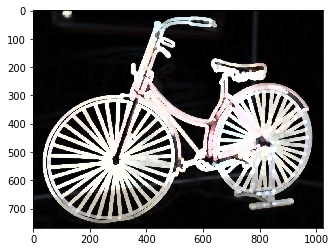

In [15]:
elKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13,13))

gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, elKernel)

plt.imshow(cv2.cvtColor(gradient, cv2.COLOR_BGR2RGB))

### OTSU Thresholding <sup>[[2]](https://en.wikipedia.org/wiki/Otsu%27s_method)</sup>
Named after Nobuyuki Otsu (大津展之 Ōtsu Nobuyuki), is used to automatically perform clustering-based image thresholding or the reduction of a graylevel image to a binary image. The algorithm assumes that the image contains two classes of pixels following bi-modal histogram foreground pixels(bicycle) and background pixels(white background), it then calculates the optimum threshold separating the two classes so that their combined spread (intra-class variance) is minimal, or equivalently (because the sum of pairwise squared distances is constant), so that their inter-class variance is maximal.

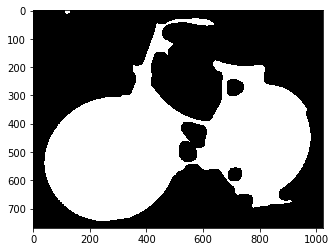

In [16]:
# Converting gradient to grayscale
gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)

#Generating a matrix called otsu using OpenCV's threshold() function.
otsu = cv2.threshold(gradient, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

# Apply a closing operation 
closingKernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (33,33))
close = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, closingKernel)
    
eroded = cv2.erode(close, None, iterations=6)

plt.imshow(eroded, cmap='gray')

### Masking 
Here I will create two images, initially all zeros (i.e. black), One image will be filled with 'Blue' wherever we think there is bicycle, the other image will be filled with 'Green' whereever we think there is no bicycle. Than create a mask image by bitwise OR of segmented image and stencil together.

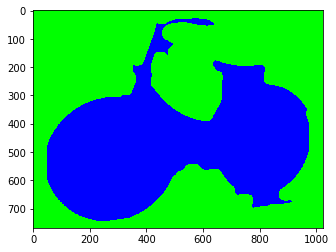

In [17]:
p = int(img.shape[1] * 0.05)
eroded[:, 0:p] = 0
eroded[:, img.shape[1] - p:] = 0

(cnting, contours, _) = cv2.findContours(eroded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

h, w, num_c = img.shape
segmask = np.zeros((h, w, num_c), np.uint8)
stencil = np.zeros((h, w, num_c), np.uint8)

for c in contours:
    # Filling the bicycle shape into segmask
    cv2.drawContours(segmask, [c], 0, (255, 0, 0), -1)
    # Lets fill in the bicycle shape into stencil as well and then re-arrange the colors using numpy
    cv2.drawContours(stencil, [c], 0, (255, 0, 0), -1)
    stencil[np.where((stencil==[0,0,0]).all(axis=2))] = [0, 255, 0]
    stencil[np.where((stencil==[255,0,0]).all(axis=2))] = [0, 0, 0]

mask = cv2.bitwise_or(stencil, segmask)

plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

### Refrences
1. https://opencv.org/
2. https://en.wikipedia.org/wiki/Image_segmentation
3. https://en.wikipedia.org/wiki/Otsu%27s_method